In [36]:
import  glob
import  matplotlib.pyplot              as     plt
import  numpy                          as     np
import  pylab                          as     pl
import  astropy.io.fits                as     fits
 
from    astropy.table                  import Table, vstack, hstack, join
from    desitarget.sv1.sv1_targetmask  import desi_mask, bgs_mask, mws_mask, scnd_mask

# Clauds LBGs

In [2]:
def gather_tile(tileid, release):
    fpath    = '/global/cscratch1/sd/mjwilson/DESILBGSPEC/{}//v4.1//tiles/cumulative/{}/*/redrock-*'.format(release, tileid)
    
    files    = glob.glob(fpath)
    files    = [fits.open(x) for x in files] 
    
    zbests   = [Table(x['REDSHIFTS'].data) for x in files]
    zbests   = vstack(zbests)
    
    fmaps    = [Table(x['FIBERMAP'].data) for x in files]
    fmaps    = vstack(fmaps) 
    
    assert  np.all(zbests['TARGETID'] == fmaps['TARGETID'])

    result   = hstack([zbests, fmaps])
    result['TARGETID'] = result['TARGETID_1']
    
    del result['TARGETID_1']
    del result['TARGETID_2']
                      
    return  {tileid: result}


In [3]:
! ls /global/cscratch1/sd/mjwilson/DESILBGSPEC/everest

v4.1


In [4]:
everest_results = {}

# everest_results.update(gather_tile(80869, 'everest'))
everest_results.update(gather_tile(80871, 'everest'))
everest_results.update(gather_tile(80872, 'everest'))

In [5]:
f3_results = {}

In [6]:
# HETDEX
f3_results.update(gather_tile(80869, 'f3'))

In [7]:
# HETDEX-2 (not in Fuji pre-test F3)
# f3_results.update(gather_tile(80870, 'f3'))

In [8]:
# Clauds
f3_results.update(gather_tile(80871, 'f3'))

In [9]:
# Clauds-2
f3_results.update(gather_tile(80872, 'f3'))

In [10]:
f3_results[80871]

CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,PLATE_RA,PLATE_DEC,TILEID,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_X,MEAN_FIBER_Y,TARGETID
float64,float64,float64,float64,int64,int64,str6,str20,int64,float64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,str3,float32,float32,int32,float64,int32,int16,str8,int32,int32,str4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,str2,float32,float32,float32,float32,str1,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int32,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,int64
11580.284447138663,-1.371317091032303e-06 .. 0.0,4.130256380739619,0.002183981385776988,5,7929,QSO,,4,0.4247503303922713,6,523,6523,3000,0,151.21143627714548,3.350971263701316,0.0,0.0,0.0,5400.0,4294967296,4,SKY,-276.42047,291.46405,-1,0.9427832886133586,63,9010,1513p032,349692,1084,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043219127,0.026860643,0.055321224,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,-1,-1,0,0,0,0,4294967296,0,0,151.21143627714548,3.350971263701316,80871,11,13420.532,4,1,0.001,0.0030895718,-0.00054545456,0.004709758,151.21143999879357,0.038993947,3.350973175273198,0.063013434,0.79265344,-276.436,291.403,616088618083025980
11946.38049569726,8.364015007226987 .. -0.4144115898784054,0.9628034293112491,9.60498910180886e-05,5,7929,GALAXY,,10,1.3705246224999428,6,474,6474,3001,0,151.118555328511,3.2898452585821985,0.0,0.0,0.0,5400.0,4294967296,4,SKY,-251.51077,274.4417,-1,0.9902652039086947,63,9010,1510p032,349691,783,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.022835655,0.021733953,0.0024964693,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,-1,-1,0,0,0,0,4294967296,0,0,151.118555328511,3.2898452585821985,80871,11,13420.532,4,1,-0.0011818182,0.004963503,0.0033636363,0.006802406,151.11855123063125,0.06576957,3.289832551410784,0.08042231,0.792695,-251.5209,274.38235,616088618078831375
8.999999999999996e+99,0.0 .. 0.0,-0.0019957014509158224,4.131159871613317e-48,1570,0,STAR,K,5,1.942668892225729e+84,6,510,6510,3002,512,151.17589244285338,3.3018136694615223,0.0,0.0,2021.2006,5400.0,4611686018427387904,1,TGT,-266.5828,278.1285,3800,0.7168580160237878,1,0,,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,3800,1,4611686018427387904,0,0,36028797018963968,0,0,0,151.17589244285338,3.3018136694615223,80871,0,0.0,4,1,1.4660909,1.4662681,-4.688182,4.6882257,151.18080802397,0.30435994,3.3194304195301,0.26646987,0.0,-268.06165,282.75745,243359268470827
12134.28510031104,7.0183325513157 .. 2.8268063299005393,1.1865008349116912,0.00011308103327749897,4,7929,GALAXY,,10,2.844969302415848,6,225,6225,3003,0,150.5742743451722,3.2729662878519545,0.0,0.0,2021.2006,5400.0,4611686018427387904,1,TGT,-112.998085,266.5294,3800,0.8060626084083589,1,0,,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,

In [11]:
scnd_types = sorted(scnd_mask.names())

In [12]:
tids = sorted(list(f3_results.keys()))
tids

[80869, 80871, 80872]

In [13]:
for tid in tids:
    print('\n\n----  TILEID: {:d}  ----\n'.format(tid))

    for x in scnd_types:
        isin  = (f3_results[tid]['SV1_SCND_TARGET'].data & scnd_mask[x]) != 0
        nscnd = np.count_nonzero(isin)
    
        print('{}\t{}'.format(x.ljust(16), nscnd))



----  TILEID: 80869  ----

BACKUP_CALIB    	71
BHB             	1
BRIGHT_HPM      	0
BRIGHT_TOO      	0
DARK_TOO        	0
DC3R2_GAMA      	0
DESILBG_BXU_FINAL	0
DESILBG_G_FINAL 	0
DESILBG_TMG_FINAL	0
FAINT_HPM       	2
FIRST_MALS      	0
GAL_CLUS_2ND    	0
GAL_CLUS_BCG    	0
GAL_CLUS_SAT    	0
HETDEX_HP       	25
HETDEX_MAIN     	1934
HPM_SOUM        	0
HSC_HIZ_SNE     	0
ISM_CGM_QGP     	0
LBG_TOMOG_COSMOS_FINAL	0
LBG_TOMOG_W3    	0
LBG_TOMOG_XMM   	0
LOW_MASS_AGN    	6
LOW_Z           	1948
M31_KNOWN       	0
M31_QSO         	0
M31_STAR        	0
MWS_CALIB       	71
MWS_CLUS_GAL_DEEP	0
MWS_MAIN_CLUSTER_SV	0
MWS_RRLYR       	1
PSF_OUT_BRIGHT  	0
PSF_OUT_DARK    	0
PV_BRIGHT       	0
PV_DARK         	0
QSO_RED         	0
SN_HOSTS        	0
SPCV            	0
STRONG_LENS     	0
UDG             	0
UNWISE_BLUE     	0
UNWISE_BLUE_BRIGHT_II	0
UNWISE_BLUE_FAINT_II	0
UNWISE_GREEN    	0
UNWISE_GREEN_II_3700	0
UNWISE_GREEN_II_3800	0
UNWISE_GREEN_II_3900	0
UNWISE_GREEN_II_4000	0
VETO         

In [14]:
keep_types = ['HETDEX_HP', 'HETDEX_MAIN', 'DESILBG_TMG_FINAL', 'DESILBG_BXU_FINAL', 'DESILBG_G_FINAL']
keep_types

['HETDEX_HP',
 'HETDEX_MAIN',
 'DESILBG_TMG_FINAL',
 'DESILBG_BXU_FINAL',
 'DESILBG_G_FINAL']

In [15]:
for sample in [everest_results, f3_results]:
  for tid in tids:
    print()

    if tid not in sample.keys():
        continue
    
    sample[tid]['IN_SAMPLE'] = np.zeros(len(sample[tid]), dtype=bool)
    
    for kt in keep_types:
        in_kt = (sample[tid]['SV1_SCND_TARGET'].data & scnd_mask[kt]) != 0
        
        sample[tid]['IN_SAMPLE'] = sample[tid]['IN_SAMPLE'].data | in_kt
        
        print('{}\t{}\t{}'.format(tid, kt.ljust(16), np.count_nonzero(in_kt)))
        
    print('{}\t{}'.format(tid, np.mean(sample[tid]['IN_SAMPLE'])))



80871	HETDEX_HP       	0
80871	HETDEX_MAIN     	0
80871	DESILBG_TMG_FINAL	931
80871	DESILBG_BXU_FINAL	1221
80871	DESILBG_G_FINAL 	842
80871	0.5988

80872	HETDEX_HP       	0
80872	HETDEX_MAIN     	0
80872	DESILBG_TMG_FINAL	613
80872	DESILBG_BXU_FINAL	1721
80872	DESILBG_G_FINAL 	1128
80872	0.6924

80869	HETDEX_HP       	25
80869	HETDEX_MAIN     	1934
80869	DESILBG_TMG_FINAL	0
80869	DESILBG_BXU_FINAL	0
80869	DESILBG_G_FINAL 	0
80869	0.3918

80871	HETDEX_HP       	0
80871	HETDEX_MAIN     	0
80871	DESILBG_TMG_FINAL	931
80871	DESILBG_BXU_FINAL	1221
80871	DESILBG_G_FINAL 	842
80871	0.5988

80872	HETDEX_HP       	0
80872	HETDEX_MAIN     	0
80872	DESILBG_TMG_FINAL	613
80872	DESILBG_BXU_FINAL	1721
80872	DESILBG_G_FINAL 	1128
80872	0.6924


In [16]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Text(0, 0.5, '$\\Delta N/\\Delta z$')

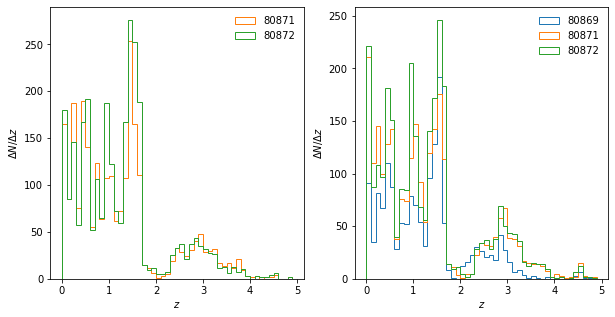

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

pl.sca(axes[0])

for tid, color in zip([80871, 80872], [colors[1], colors[2]]):
    isin = everest_results[tid]['IN_SAMPLE']
    
    pl.hist(everest_results[tid]['Z'][isin], bins=np.arange(0.0, 5.0, 0.1), histtype='step', label=tid, color=color)

pl.legend(frameon=False)
pl.xlabel('$z$')
pl.ylabel('$\Delta N/\Delta z$')

pl.sca(axes[1])

for tid in tids:
    isin = f3_results[tid]['IN_SAMPLE']
    
    pl.hist(f3_results[tid]['Z'][isin], bins=np.arange(0.0, 5.0, 0.1), histtype='step', label=tid)

pl.legend(frameon=False)

pl.xlabel('$z$')
pl.ylabel('$\Delta N/\Delta z$')

In [18]:
np.mean(f3_results[80871]['TARGETID'] == everest_results[80871]['TARGETID'])

0.9996

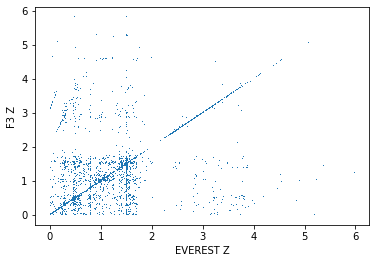

In [19]:
to_plot = 'Z'

for tid in [80871]:
    isin = f3_results[tid]['IN_SAMPLE']

    # assert  np.all(f3_results[tid]['TARGETID'] == everest_results[tid]['TARGETID'])
    
    pl.plot(everest_results[tid][to_plot][isin], f3_results[tid][to_plot][isin], marker=',', lw=0.0)
    
    pl.xlabel('EVEREST Z')
    pl.ylabel('F3 Z')

In [20]:
for tid in tids:
    utypes, cnts = np.unique(f3_results[tid]['SPECTYPE'].data, return_counts=True)
    
    print(tid, utypes, cnts)

80869 ['BC03' 'GALAXY' 'LBG' 'QSO' 'STAR'] [  63 2925  235  236 1541]
80871 ['BC03' 'GALAXY' 'LBG' 'QSO' 'STAR'] [ 163 3119  332  359 1027]
80872 ['BC03' 'GALAXY' 'LBG' 'QSO' 'STAR'] [ 242 2989  288  313 1168]


In [46]:
ErinVI = Table.read('/global/cscratch1/sd/mjwilson/DESILBGSPEC/Erin/desi-hetdex-v1.0.fits')
ErinVI

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,BRICKNAME,EBV,FLUX_W1,FLUX_W2,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,TILEID,COADD_NUMEXP,COADD_EXPTIME,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_X,MEAN_FIBER_Y,MEAN_FIBER_RA,MEAN_FIBER_DEC,MEAN_FIBERASSIGN_X,MEAN_FIBERASSIGN_Y,FIRST_NIGHT,LAST_NIGHT,NUM_NIGHT,FIRST_EXPID,LAST_EXPID,NUM_EXPID,FIRST_TILEID,LAST_TILEID,NUM_TILEID,FIRST_FIBER,LAST_FIBER,NUM_FIBER,FIRST_MJD,LAST_MJD,NUM_MJD,PSF_TO_FIBER_SPECFLUX,FIBERASSIGN_X,FIBERASSIGN_Y,PLATE_RA,PLATE_DEC,COADD_NUMNIGHT,COADD_NUMTILE,STD_FIBER_RA,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,CHI2,Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE,detectid,RA_HETDEX,DEC_HETDEX,wave,flux,flux_err,sn,linewidth,chi2,plae_classification,source_type,z_hetdex,src_separation,best_z,best_pz,sn_im,apcor_api,VI_z,VI_quality
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,int32,float64,int32,int16,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,int16,int64,bytes2,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,int32,int16,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,int32,int32,int16,int32,int32,int16,int32,int32,int16,int32,int32,int16,float32,float32,int16,float64,float32,float32,float64,float64,int16,int16,float32,float32,float32,float64,float64,float64,int64,int64,bytes6,bytes20,int64,float64,int32,int32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes4,float64,float32,float64,float64,float64,float64,float64,int64
103606497837059,1,397,1397,518,512,224.089111328125,50.0955924987793,0.0,0.0,2021.1924,5400.0,4611686018427387904,1,TGT,4100,0.5387504567218175,1,0,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0,0,,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,4100,1,4611686018427387904,0,0,8388608,0,0,0,80870,0,0.0,-2.0596,2.059608,-5.2166,5.2166014,148.7436,-348.7832,224.07539715309431,50.11516834071459,nan,nan,--,--,--,--,--,--,--,--,--,--,--,--,nan,nan,--,nan,146.67651,-354.05673,224.089111328125,50.0955924987793,3,1,0.19516109,0.0493325,0.0,8.999999999999996e+99,-0.0019957014509158224,4.131159871613317e-48,1570,0,STAR,K,5,1.942668892225729e+84,--,--,2102264288,224.08911,50.095592,4815.1,19.26054,2.9309516,5.52,4.29,1.03,0.999,lae,2.9608612060546875,0.0,2.9608612060546875,0.949999988079071,3.506540536880493,0.5185121685159076,nan,-1
103606497837060,1,419,1419,529,0,224.06594848632812,50.08247375488281,0.0,0.0,2021.1924,5400.0,4611686018427387904,1,TGT,4100,0.6470453259533693,1,0,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0,0,,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,4100,1,4611686018427387904,0,0,8388608,0,0,0,80870,5,8140.226,0.0028,0.006542171,-0.0012,0.0028982754,150.6048,-357.5998,224.06596529969542,50.08247803003104,nan,nan,--,--,--,--,--,--,--,--,--,--,--,--,nan,nan,--,nan,150.59998,-357.65894,224.06594848632812,50.08247375488281,3,1,0.20368443,0.035812348,0.7926747,12110.121168673038,1.582186534178502,7.936175500814655e-05,0,7928,GALAXY,,10,11.173452407121658,--,--,2102264283

In [22]:
ArjunVI = [Table.read(x) for x in glob.glob('/global/cscratch1/sd/mjwilson/DESILBGSPEC/Arjun/*.csv')]

# len(ArjunVI)

ArjunVI[3]['VI_z'][0] = 4.5
ArjunVI[3]['VI_z'].data[ ArjunVI[3]['VI_z'].mask] = -99.
ArjunVI[3]['VI_z'] = ArjunVI[3]['VI_z'].data.data.astype(np.float64)

ArjunVI = vstack(ArjunVI)
ArjunVI

TARGETID,TILEID,Spec_version,Redrock_version,Template_version,Redrock_spectype,Redrock_z,Redrock_deltachi2,VI_scanner,VI_quality,VI_issue,VI_z,VI_spectype,VI_comment
int64,int64,str6,str6,int64,str6,float64,float64,str3,int64,str2,float64,str6,str208
39627805369041952,80872,0.45.0,0.15.0,-1,QSO,2.9544,21002.3,dey,4,--,2.9544,QSO,narrow line AGN
39627871781652060,80872,0.45.0,0.15.0,-1,GALAXY,0.4777,15.1,dey,3,RC,1.602,GALAXY,[OII]; CIII]; CIV in emission
39627871794234405,80872,0.45.0,0.15.0,-1,GALAXY,0.0734,94.3,dey,0,--,--,GALAXY,possibly z=2.5-ish; could be at 2.36
234520884281368,80871,0.45.0,0.15.0,-1,GALAXY,0.1229,192.8,dey,4,R,2.4431,GALAXY,strong asymmetric emission line at 4186; blue continuum + break
234520888475649,80871,0.45.0,0.15.0,-1,GALAXY,0.7797,42.5,dey,4,R,2.1886,GALAXY,continuum + break + CIV/SiIV/OI/SiII/CIII] etc
234520884281357,80871,0.45.0,0.15.0,-1,GALAXY,0.2331,26.5,dey,3,R,2.9677,GALAXY,weak Lya + break at 4825 (but could be compromised by B-arm calib/sub)
234520888475656,80871,0.45.0,0.15.0,-1,GALAXY,0.2424,28.4,dey,3,R,2.8424,GALAXY,broad Lya abspn? z from CIII]/CIV/SiIV/OI etc. but could be a bit higher
234520888475672,80871,0.45.0,0.15.0,-1,GALAXY,0.272,4.0,dey,3,R,2.7517,GALAXY,z from Lya but lots of continuum and abspn lines z_abs=2.7465
234520884281364,80871,0.45.0,0.15.0,-1,GALAXY,0.0804,8873.7,dey,4,--,0.0804,GALAXY,lots of emission lines - star forming galaxy


In [23]:
ArjunVI['VI_comment']

narrow line AGN
[OII]; CIII]; CIV in emission
possibly z=2.5-ish; could be at 2.36
strong asymmetric emission line at 4186; blue continuum + break
continuum + break + CIV/SiIV/OI/SiII/CIII] etc
weak Lya + break at 4825 (but could be compromised by B-arm calib/sub)
broad Lya abspn? z from CIII]/CIV/SiIV/OI etc. but could be a bit higher
z from Lya but lots of continuum and abspn lines z_abs=2.7465
lots of emission lines - star forming galaxy
beware of break; but looks like abs ine z matches; possible alternative solution at z=2.82
abs line redshift is uncertain


Text(0.5, 0, 'Z')

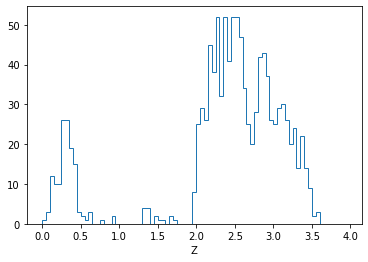

In [32]:
_ = pl.hist(ErinVI['VI_z'], bins=np.arange(0.0, 4.0, 0.05), histtype='step')

pl.xlabel('Z')

In [47]:
f3_ErinVI = join(f3_results[80869], ErinVI['VI_z', 'TARGETID', 'z_hetdex'], join_type='left', keys='TARGETID')
f3_ErinVI

CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,PLATE_RA,PLATE_DEC,TILEID,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_X,MEAN_FIBER_Y,TARGETID,IN_SAMPLE,VI_z,z_hetdex
float64,float64,float64,float64,int64,int64,str6,str20,int64,float64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,str3,float32,float32,int32,float64,int32,int16,str8,int32,int32,str4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,str2,float32,float32,float32,float32,str1,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int32,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,int64,bool,float64,float64
18516.157104492188,1007.0870098910453 .. 0.7334403149342991,0.19247476374190925,6.864105216363513e-07,0,7929,GALAXY,,10,70882.63385009766,2,95,2095,1291,0,164.917355319435,51.2669700812739,0.0,0.0,2021.1924,5400.0,4611686018427387904,1,TGT,166.01443,-55.730843,3000,0.4333077824588428,1,0,,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,3000,1,4611686018427387904,0,0,2048,0,0,0,164.917355319435,51.2669700812739,80869,12,12720.663,2,1,0.00066666666,0.0046007247,0.00225,0.006461424,164.91735990157073,0.16683333,51.26696094906557,0.08907759,0.7914672,165.99442,-55.736916,50848537247744,False,--,--
8.999999999999996e+99,0.0 .. 0.0,-0.0019957014509158224,4.131159871613317e-48,1570,0,STAR,K,5,1.942668892225729e+84,1,509,1509,576,512,164.3549346923828,50.34974670410156,0.0,0.0,2021.1924,5400.0,4611686018427387904,1,TGT,265.7067,-287.70654,4100,0.9656675573531227,1,0,,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,4100,1,4611686018427387904,0,0,8388608,0,0,0,164.3549346923828,50.34974670410156,80869,0,0.0,2,1,4.052583,4.105044,2.3791666,2.4357777,164.38010167678007,23.22139,50.34049808876434,7.253278,0.0,261.63525,-290.02917,103609740034049,True,nan,2.785829782485962
12303.154611378908,17.91188150459629 .. 2.052474920652761,1.6015856359485952,0.0001164510552955895,4,7929,GALAXY,,10,1.7581936419010162,1,523,1523,557,0,164.31471252441406,50.33249282836914,0.0,0.0,2021.1924,5400.0,4611686018427387904,1,TGT,272.73096,-292.37964,4100,0.9502864814034285,1,0,,0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,4100,1,4611686018427387904,0,0,8388608,0,0,0,164.31471252441406,50.33249282836914,80869,12,12720.663,2,1,-0.0028333333,0.0064678695,0.0059166667,0.0131877465,164.31469787273872,0.19539951,50.33247063735592,0.16030128,0.79346454,272.71457,-292.32657,103609740034051,True,nan,3.274432897567749
9612.410069406033,17.35223827912595 .. 0.11239070903059079,0.6103210339977279,5.550280502650673e-05,4,7929,GALAXY,,10,6.859054245054722,1,508,1508,876,0,164.40438842773438,50.324378967285156,0.0,0.0,2021.1924,5400.0,4611686018427387904,1,TGT,257.8534,-294.2825,4100,0.8653706753857008,1,0,,0,0,,0.0,0.

Text(0.5, 1.0, 'In sample: 4996 galaxies')

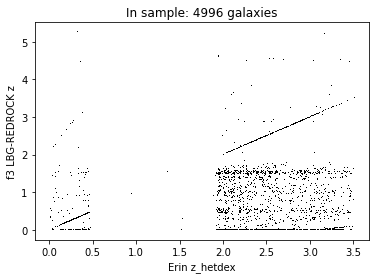

In [50]:
# to_plot = 'VI_z'
to_plot = 'z_hetdex'

isin = f3_ErinVI[to_plot] > 0.0

pl.plot(f3_ErinVI[to_plot][isin], f3_ErinVI['Z'][isin], marker=',', lw=0.0, color='k')

pl.xlabel('Erin {}'.format(to_plot))
pl.ylabel('f3 LBG-REDROCK z')

pl.title('In sample: {:d} galaxies'.format(np.count_nonzero(isin)))

# Done.